## 1. Import Library

In [38]:
# Basic Library
import pandas as pd
import numpy as np
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# HP Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
from lightgbm import LGBMClassifier
import xgboost as xgb
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## 2. Import Data

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")

## 3-1. LightGBM Modeling

In [3]:
pred_dict = {}
pred_test_dict = {}

### (1) HP Tuning

In [4]:
train_x = train.iloc[:, 1:-1]
train_y = train.iloc[:, -1:]
test_x = test.iloc[:, 1:]

In [7]:
def lgb_objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        'learning_rate': trial.suggest_uniform("learning_rate", 0.005, 0.05),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0.0, 1),
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0.0, 1),
        "max_depth": trial.suggest_int("max_depth", 5, 8),
        "num_leaves": trial.suggest_int("num_leaves", 200, 1200),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0), # feature_fraction
        "subsample": trial.suggest_uniform("subsample", 0.0, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 10),
        "max_bin": trial.suggest_int("max_bin", 150, 400),
    }
    
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()

        lgbmodel = LGBMClassifier(**params_lgb)
                                                                                        # 진행상황 보고싶을때 -1을 100으로
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=-1) 
        cv[val_idx, :] = lgbmodel.predict_proba(x_val)
        
#     print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(train_y, np.argmax(cv, axis=1)))

    
    return accuracy_score(train_y, np.argmax(cv, axis=1))

In [8]:
sampler = TPESampler(seed=42)
lgb_study = optuna.create_study(study_name="lgb_parameter_opt", direction="maximize", sampler=sampler)
lgb_study.optimize(lgb_objective, n_trials=15)

lgb_best_hyperparams = lgb_study.best_trial.params
lgb_base_hyperparams = {'objective':'multiclass', 'n_estimators':10000,
                        'lambda_l1':lgb_best_hyperparams['reg_alpha'],
                        'lambda_l2':lgb_best_hyperparams['reg_lambda'],
                        'reg_alpha':None, 'reg_lambda':None
                       }
lgb_best_hyperparams.update(lgb_base_hyperparams)
print("The best hyperparameters are:\n", lgb_best_hyperparams)

[I 2022-03-15 21:04:24,592] A new study created in memory with name: lgb_parameter_opt
[I 2022-03-15 21:04:32,724] Trial 0 finished with value: 0.75203426124197 and parameters: {'learning_rate': 0.021854305348131316, 'reg_alpha': 0.9507143064099162, 'reg_lambda': 0.7319939418114051, 'max_depth': 7, 'num_leaves': 356, 'colsample_bytree': 0.5779972601681014, 'subsample': 0.05808361216819946, 'subsample_freq': 9, 'min_child_samples': 7, 'max_bin': 327}. Best is trial 0 with value: 0.75203426124197.


accuracy_score: 0.75203426124197


[I 2022-03-15 21:05:21,459] Trial 1 finished with value: 0.8329764453961456 and parameters: {'learning_rate': 0.0059263022433111105, 'reg_alpha': 0.9699098521619943, 'reg_lambda': 0.8324426408004217, 'max_depth': 5, 'num_leaves': 382, 'colsample_bytree': 0.5917022549267169, 'subsample': 0.3042422429595377, 'subsample_freq': 6, 'min_child_samples': 5, 'max_bin': 223}. Best is trial 1 with value: 0.8329764453961456.


accuracy_score: 0.8329764453961456


[I 2022-03-15 21:05:27,941] Trial 2 finished with value: 0.8119914346895075 and parameters: {'learning_rate': 0.03253338026250708, 'reg_alpha': 0.13949386065204183, 'reg_lambda': 0.29214464853521815, 'max_depth': 6, 'num_leaves': 656, 'colsample_bytree': 0.8925879806965068, 'subsample': 0.19967378215835974, 'subsample_freq': 6, 'min_child_samples': 6, 'max_bin': 161}. Best is trial 1 with value: 0.8329764453961456.


accuracy_score: 0.8119914346895075


[I 2022-03-15 21:05:41,077] Trial 3 finished with value: 0.8385438972162741 and parameters: {'learning_rate': 0.032339518335564726, 'reg_alpha': 0.17052412368729153, 'reg_lambda': 0.06505159298527952, 'max_depth': 8, 'num_leaves': 1166, 'colsample_bytree': 0.9041986740582306, 'subsample': 0.3046137691733707, 'subsample_freq': 1, 'min_child_samples': 7, 'max_bin': 260}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8385438972162741


[I 2022-03-15 21:06:09,175] Trial 4 finished with value: 0.8329764453961456 and parameters: {'learning_rate': 0.010491720568015048, 'reg_alpha': 0.4951769101112702, 'reg_lambda': 0.034388521115218396, 'max_depth': 8, 'num_leaves': 459, 'colsample_bytree': 0.831261142176991, 'subsample': 0.31171107608941095, 'subsample_freq': 6, 'min_child_samples': 6, 'max_bin': 196}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8329764453961456


[I 2022-03-15 21:06:19,332] Trial 5 finished with value: 0.7922912205567452 and parameters: {'learning_rate': 0.04863130824940514, 'reg_alpha': 0.7751328233611146, 'reg_lambda': 0.9394989415641891, 'max_depth': 8, 'num_leaves': 798, 'colsample_bytree': 0.9609371175115584, 'subsample': 0.0884925020519195, 'subsample_freq': 2, 'min_child_samples': 1, 'max_bin': 231}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.7922912205567452


[I 2022-03-15 21:06:39,320] Trial 6 finished with value: 0.7961456102783726 and parameters: {'learning_rate': 0.022490478036026693, 'reg_alpha': 0.2713490317738959, 'reg_lambda': 0.8287375091519293, 'max_depth': 6, 'num_leaves': 481, 'colsample_bytree': 0.7713480415791243, 'subsample': 0.14092422497476265, 'subsample_freq': 9, 'min_child_samples': 1, 'max_bin': 397}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.7961456102783726


[I 2022-03-15 21:06:53,737] Trial 7 finished with value: 0.8316916488222698 and parameters: {'learning_rate': 0.03975101461834959, 'reg_alpha': 0.1987156815341724, 'reg_lambda': 0.005522117123602399, 'max_depth': 8, 'num_leaves': 907, 'colsample_bytree': 0.8645035840204937, 'subsample': 0.7712703466859457, 'subsample_freq': 1, 'min_child_samples': 4, 'max_bin': 179}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8316916488222698


[I 2022-03-15 21:07:05,288] Trial 8 finished with value: 0.8269807280513919 and parameters: {'learning_rate': 0.04383965416440171, 'reg_alpha': 0.6232981268275579, 'reg_lambda': 0.3308980248526492, 'max_depth': 5, 'num_leaves': 511, 'colsample_bytree': 0.6625916610133735, 'subsample': 0.7296061783380641, 'subsample_freq': 7, 'min_child_samples': 9, 'max_bin': 268}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8269807280513919


[I 2022-03-15 21:08:02,746] Trial 9 finished with value: 0.8261241970021413 and parameters: {'learning_rate': 0.010381741067223577, 'reg_alpha': 0.713244787222995, 'reg_lambda': 0.7607850486168974, 'max_depth': 7, 'num_leaves': 971, 'colsample_bytree': 0.7468977981821954, 'subsample': 0.5227328293819941, 'subsample_freq': 5, 'min_child_samples': 1, 'max_bin': 177}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8261241970021413


[I 2022-03-15 21:08:25,469] Trial 10 finished with value: 0.828693790149893 and parameters: {'learning_rate': 0.031372948924236296, 'reg_alpha': 0.005997182955817026, 'reg_lambda': 0.5180371644945151, 'max_depth': 7, 'num_leaves': 1184, 'colsample_bytree': 0.953832397641259, 'subsample': 0.9597707459454201, 'subsample_freq': 3, 'min_child_samples': 10, 'max_bin': 311}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.828693790149893


[I 2022-03-15 21:08:49,379] Trial 11 finished with value: 0.8342612419700214 and parameters: {'learning_rate': 0.017634242940786696, 'reg_alpha': 0.40722506998049707, 'reg_lambda': 0.5109254638413363, 'max_depth': 5, 'num_leaves': 267, 'colsample_bytree': 0.5369184983570693, 'subsample': 0.4002255810220492, 'subsample_freq': 4, 'min_child_samples': 4, 'max_bin': 246}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8342612419700214


[I 2022-03-15 21:09:17,157] Trial 12 finished with value: 0.8355460385438972 and parameters: {'learning_rate': 0.01934521448400128, 'reg_alpha': 0.3743780629884814, 'reg_lambda': 0.46870521888784233, 'max_depth': 6, 'num_leaves': 227, 'colsample_bytree': 0.5167929424672362, 'subsample': 0.4812884929660226, 'subsample_freq': 4, 'min_child_samples': 3, 'max_bin': 271}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8355460385438972


[I 2022-03-15 21:09:36,288] Trial 13 finished with value: 0.8278372591006424 and parameters: {'learning_rate': 0.028180326743751198, 'reg_alpha': 0.32711556453252894, 'reg_lambda': 0.20197183757230486, 'max_depth': 6, 'num_leaves': 1165, 'colsample_bytree': 0.7000831872063953, 'subsample': 0.5460502071617208, 'subsample_freq': 1, 'min_child_samples': 8, 'max_bin': 307}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8278372591006424


[I 2022-03-15 21:10:05,299] Trial 14 finished with value: 0.8364025695931477 and parameters: {'learning_rate': 0.03654725381303922, 'reg_alpha': 0.03707527078075118, 'reg_lambda': 0.6206950820137881, 'max_depth': 7, 'num_leaves': 652, 'colsample_bytree': 0.5125324103836217, 'subsample': 0.6417871934804688, 'subsample_freq': 3, 'min_child_samples': 3, 'max_bin': 354}. Best is trial 3 with value: 0.8385438972162741.


accuracy_score: 0.8364025695931477
The best hyperparameters are:
 {'learning_rate': 0.032339518335564726, 'reg_alpha': None, 'reg_lambda': None, 'max_depth': 8, 'num_leaves': 1166, 'colsample_bytree': 0.9041986740582306, 'subsample': 0.3046137691733707, 'subsample_freq': 1, 'min_child_samples': 7, 'max_bin': 260, 'objective': 'multiclass', 'n_estimators': 10000, 'lambda_l1': 0.17052412368729153, 'lambda_l2': 0.06505159298527952}


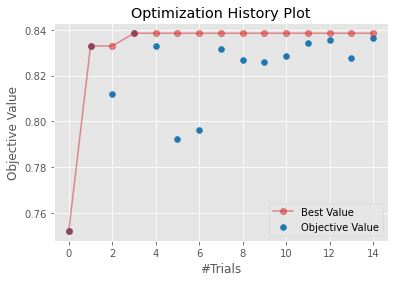

In [9]:
optuna.visualization.matplotlib.plot_optimization_history(lgb_study);

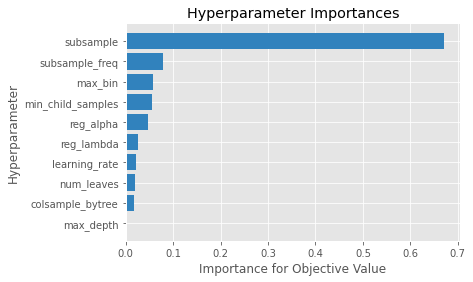

In [10]:
optuna.visualization.matplotlib.plot_param_importances(lgb_study);

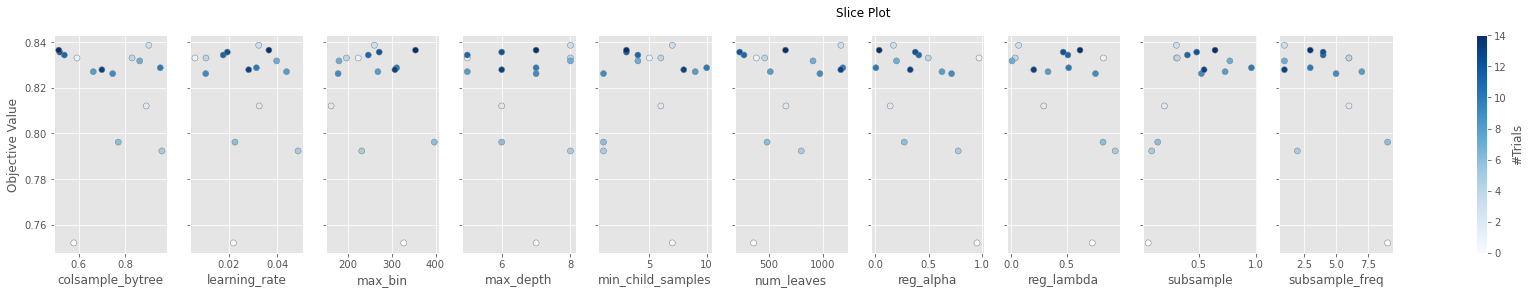

In [11]:
optuna.visualization.matplotlib.plot_slice(lgb_study);

### (2) Training

In [12]:
lucky_seeds = [0, 42, 2022] # Lucky seed 늘려가면서 하기

# lgb_pred = np.zeros((test_x.shape[0], 4))

for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # CV 늘려가면서 하기
    cv=np.zeros((train_x.shape[0], 4))
    pred_test = np.zeros((test_x.shape[0], 4), dtype=float)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
#         print(f"{n+1} Fold Training.....")
        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()

        lgbmodel = LGBMClassifier(**lgb_best_hyperparams)
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=-1)
        
        cv[val_idx,:] = lgbmodel.predict_proba(x_val)
        #print(f'fold{n+1} multi_logloss: {log_loss(y_val, cv[val_idx, :])}') # Fold마다 점수 체크하려면 주석 해제
        pred_test += lgbmodel.predict_proba(test_x) / 5 # CV 바꾸면 이 숫자도 똑같이 바꿔야함
    pred_dict['lgb'+str(seed)] = cv
    pred_test_dict['lgb'+str(seed)] = pred_test
#     print(f'seed {seed}', 'multi_logloss :', log_loss(train_y, cv))
    print(f'seed {seed}', 'accuracy_score :', accuracy_score(train_y, np.argmax(cv, axis=1)))

#         val_cls = np.argmax(val_pred, axis=1)

#         fold_lgb_acc = accuracy_score(y_val, val_cls)
#         lgb_acc.append(fold_lgb_acc)

#         print(f'fold{n+1} score: {fold_lgb_acc}')
#         fold_pred = lgbmodel.predict_proba(test_x) / skf.n_splits
#         lgb_pred += fold_pred

seed 0 accuracy_score : 0.8308351177730193
seed 42 accuracy_score : 0.8308351177730193
seed 2022 accuracy_score : 0.8351177730192719


## 3-2. XGB Modeling

In [21]:
def xgb_objective(trial: Trial) -> float:
    params_xgb = {
        "random_state": 91373,
        "verbose": None,
        "num_class": 4,
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.05),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0.0, 0.1), # default=0
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0.0, 0.1), # default=1
        "max_depth": trial.suggest_int("max_depth", 8, 15),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0), # default=0
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.5, 1.0),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0), # default=1,
        "min_child_weight": trial.suggest_uniform("min_child_weight", 1, 5), # default=1
        #"max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    # CV=5로 튜닝
    
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]
        
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dvalid = xgb.DMatrix(x_val, label=y_val)
        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                            # 진행상황 보고싶을때 None을 100으로
        xgbmodel = xgb.train(params_xgb, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)

        cv[val_idx, :] = xgbmodel.predict(dvalid)
        
#     print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(train_y, np.argmax(cv, axis=1)))

    
    return accuracy_score(train_y, np.argmax(cv, axis=1))

In [22]:
sampler = TPESampler(seed=42)
xgb_study = optuna.create_study(study_name="xgb_parameter_opt", direction="maximize", sampler=sampler)
xgb_study.optimize(xgb_objective, n_trials=10)

xgb_best_hyperparams = xgb_study.best_trial.params
xgb_base_hyperparams = {'objective':'multi:softprob', "num_class": 4, "eval_metric": "mlogloss", "random_state": 91373}
xgb_best_hyperparams.update(xgb_base_hyperparams)
print("The best hyperparameters are:\n", xgb_best_hyperparams)

[I 2022-03-15 21:36:19,944] A new study created in memory with name: xgb_parameter_opt
[I 2022-03-15 21:36:52,400] Trial 0 finished with value: 0.8244111349036403 and parameters: {'learning_rate': 0.0249816047538945, 'reg_alpha': 0.09507143064099162, 'reg_lambda': 0.0731993941811405, 'max_depth': 12, 'colsample_bytree': 0.5780093202212182, 'colsample_bylevel': 0.5779972601681014, 'subsample': 0.5290418060840998, 'min_child_weight': 4.46470458309974}. Best is trial 0 with value: 0.8244111349036403.


accuracy_score: 0.8244111349036403


[I 2022-03-15 21:37:23,997] Trial 1 finished with value: 0.8265524625267666 and parameters: {'learning_rate': 0.034044600469728355, 'reg_alpha': 0.07080725777960455, 'reg_lambda': 0.0020584494295802446, 'max_depth': 15, 'colsample_bytree': 0.9162213204002109, 'colsample_bylevel': 0.6061695553391381, 'subsample': 0.5909124836035503, 'min_child_weight': 1.7336180394137353}. Best is trial 1 with value: 0.8265524625267666.


accuracy_score: 0.8265524625267666


[I 2022-03-15 21:38:09,829] Trial 2 finished with value: 0.8226980728051392 and parameters: {'learning_rate': 0.02216968971838151, 'reg_alpha': 0.052475643163223784, 'reg_lambda': 0.04319450186421158, 'max_depth': 10, 'colsample_bytree': 0.8059264473611898, 'colsample_bylevel': 0.569746930326021, 'subsample': 0.6460723242676091, 'min_child_weight': 2.465447373174767}. Best is trial 1 with value: 0.8265524625267666.


accuracy_score: 0.8226980728051392


[I 2022-03-15 21:38:55,168] Trial 3 finished with value: 0.819271948608137 and parameters: {'learning_rate': 0.02824279936868144, 'reg_alpha': 0.07851759613930137, 'reg_lambda': 0.019967378215835975, 'max_depth': 12, 'colsample_bytree': 0.7962072844310213, 'colsample_bylevel': 0.5232252063599989, 'subsample': 0.8037724259507192, 'min_child_weight': 1.6820964947491661}. Best is trial 1 with value: 0.8265524625267666.


accuracy_score: 0.819271948608137


[I 2022-03-15 21:40:17,095] Trial 4 finished with value: 0.8167023554603854 and parameters: {'learning_rate': 0.01260206371941118, 'reg_alpha': 0.09488855372533334, 'reg_lambda': 0.09656320330745594, 'max_depth': 14, 'colsample_bytree': 0.6523068845866853, 'colsample_bylevel': 0.5488360570031919, 'subsample': 0.8421165132560784, 'min_child_weight': 2.760609974958405}. Best is trial 1 with value: 0.8265524625267666.


accuracy_score: 0.8167023554603854


[I 2022-03-15 21:41:23,833] Trial 5 finished with value: 0.819271948608137 and parameters: {'learning_rate': 0.014881529393791153, 'reg_alpha': 0.04951769101112702, 'reg_lambda': 0.0034388521115218396, 'max_depth': 15, 'colsample_bytree': 0.6293899908000085, 'colsample_bylevel': 0.831261142176991, 'subsample': 0.6558555380447055, 'min_child_weight': 3.0802720847112433}. Best is trial 1 with value: 0.8265524625267666.


accuracy_score: 0.819271948608137


[I 2022-03-15 21:42:09,315] Trial 6 finished with value: 0.8244111349036403 and parameters: {'learning_rate': 0.03186841117373119, 'reg_alpha': 0.018485445552552705, 'reg_lambda': 0.09695846277645587, 'max_depth': 14, 'colsample_bytree': 0.9697494707820946, 'colsample_bylevel': 0.9474136752138245, 'subsample': 0.7989499894055425, 'min_child_weight': 4.687496940092467}. Best is trial 1 with value: 0.8265524625267666.


accuracy_score: 0.8244111349036403


[I 2022-03-15 21:43:34,209] Trial 7 finished with value: 0.819271948608137 and parameters: {'learning_rate': 0.013539700082076781, 'reg_alpha': 0.019598286241914523, 'reg_lambda': 0.004522728891053806, 'max_depth': 10, 'colsample_bytree': 0.6943386448447411, 'colsample_bylevel': 0.6356745158869479, 'subsample': 0.9143687545759647, 'min_child_weight': 2.427013306774357}. Best is trial 1 with value: 0.8265524625267666.


accuracy_score: 0.819271948608137


[I 2022-03-15 21:44:34,983] Trial 8 finished with value: 0.8197002141327623 and parameters: {'learning_rate': 0.02123738038749523, 'reg_alpha': 0.05426960831582485, 'reg_lambda': 0.014092422497476265, 'max_depth': 14, 'colsample_bytree': 0.5372753218398854, 'colsample_bylevel': 0.9934434683002586, 'subsample': 0.8861223846483287, 'min_child_weight': 1.7948627261366896}. Best is trial 1 with value: 0.8265524625267666.


accuracy_score: 0.8197002141327623


[I 2022-03-15 21:46:29,647] Trial 9 finished with value: 0.8214132762312634 and parameters: {'learning_rate': 0.010220884684944096, 'reg_alpha': 0.08154614284548342, 'reg_lambda': 0.07068573438476171, 'max_depth': 13, 'colsample_bytree': 0.8856351733429728, 'colsample_bylevel': 0.5370223258670452, 'subsample': 0.6792328642721364, 'min_child_weight': 1.4634762381005189}. Best is trial 1 with value: 0.8265524625267666.


accuracy_score: 0.8214132762312634
The best hyperparameters are:
 {'learning_rate': 0.034044600469728355, 'reg_alpha': 0.07080725777960455, 'reg_lambda': 0.0020584494295802446, 'max_depth': 15, 'colsample_bytree': 0.9162213204002109, 'colsample_bylevel': 0.6061695553391381, 'subsample': 0.5909124836035503, 'min_child_weight': 1.7336180394137353, 'objective': 'multi:softprob', 'num_class': 4, 'eval_metric': 'mlogloss', 'random_state': 91373}


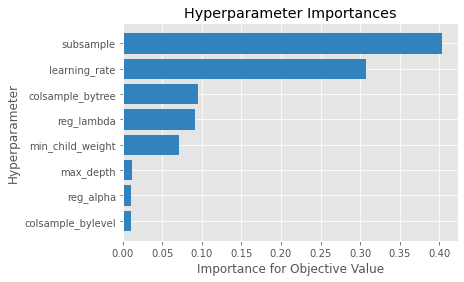

In [23]:
optuna.visualization.matplotlib.plot_param_importances(xgb_study);

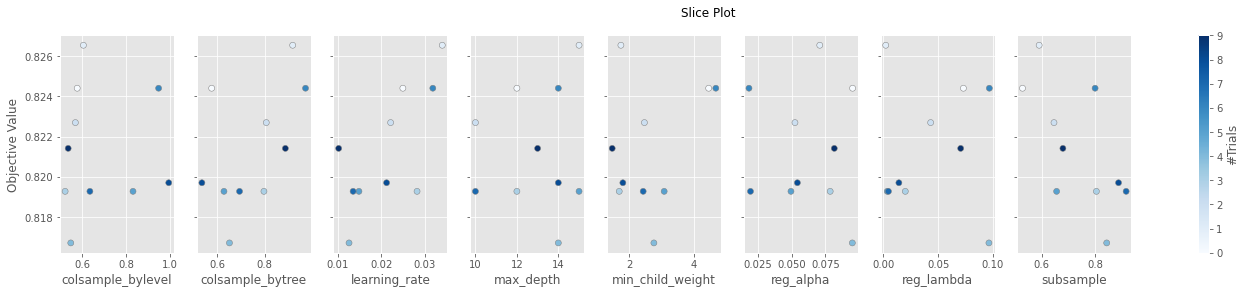

In [24]:
optuna.visualization.matplotlib.plot_slice(xgb_study);

In [25]:
lucky_seeds = [0, 42, 2022]
xgtest = xgb.DMatrix(test_x)
for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # CV 늘려가면서 하기
    cv=np.zeros((train_x.shape[0], 4))
    pred_test = np.zeros((test_x.shape[0], 4), dtype=float)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
#         print(f"{n+1} Fold Training.....")
        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()
        
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dvalid = xgb.DMatrix(x_val, label=y_val)
        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
                                                                                            # 진행상황 보고싶을때 None을 100으로
        xgbmodel = xgb.train(xgb_best_hyperparams, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)

        cv[val_idx, :] = xgbmodel.predict(dvalid)
        #print(f'fold{n+1} multi_logloss: {log_loss(y_val, cv[val_idx, :])}') # Fold마다 점수 체크하려면 주석 해제
        pred_test += xgbmodel.predict(xgtest) / 5 # CV 바꾸면 이 숫자도 똑같이 바꿔야함
        
    pred_dict['xgb'+str(seed)] = cv
    pred_test_dict['xgb'+str(seed)] = pred_test
    print(seed, 'multi_logloss :', log_loss(train_y, cv))
    print(f'seed {seed}', 'accuracy_score :', accuracy_score(train_y, np.argmax(cv, axis=1)))

0 multi_logloss : 0.46075765039082045
seed 0 accuracy_score : 0.8265524625267666
42 multi_logloss : 0.45935011154584404
seed 42 accuracy_score : 0.8265524625267666
2022 multi_logloss : 0.4642987178301548
seed 2022 accuracy_score : 0.8304068522483941


## 3-3. CNN Modeling

### (1) HP Tuning

In [26]:
train_x = train.iloc[:, 1:-1]
test_x = test.iloc[:, 1:]

train_x = np.array(train_x).reshape(-1, 8, 4, 1)
test_x = np.array(test_x).reshape(-1, 8, 4, 1)

ohe = OneHotEncoder(sparse = False)
train_y = ohe.fit_transform(train[['target']])

In [ ]:
def create_model(filter_1, filter_2, mid_units):
    
    model = Sequential()
    model.add(Conv2D(filters=filter_1, kernel_size=(2, 2), padding="same", activation="elu", input_shape=(8, 4, 1)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=filter_2, kernel_size=(2, 2), padding="same", activation="elu"))
    model.add(BatchNormalization())
    #model.add(Dropout(dropout_rate[i+1]))
            
    model.add(GlobalAveragePooling2D())
    model.add(Dense(mid_units, activation='relu'))
    #model.add(Dropout(dropout_rate[-1]))
    model.add(Dense(4, activation='softmax'))
    
    return model

In [ ]:
def cnn_objective(trial: Trial) -> float:
    
    #clear_session
    keras.backend.clear_session()
    
    #number of the unit
    mid_units = int(trial.suggest_discrete_uniform("mid_units", 64, 128, 16))
    
    #number of the each convolution layer filter
    filter_1 = int(trial.suggest_discrete_uniform("filter_1", 64, 128, 32))
    filter_2 = int(trial.suggest_discrete_uniform("filter_2", 128, 256, 32))

    #Dropout
    #dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    #dropout_rate = [int(trial.suggest_uniform("dropout_rate"+str(ii), 0.0, 0.5)) for ii in range(num_layer+1)]
    
        
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train.target)):

        x_train, y_train = train_x[train_idx], train_y[train_idx]
        x_val, y_val = train_x[val_idx], train_y[val_idx]
        
        mc = ModelCheckpoint(f"model_{n+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)
        
        model = create_model(filter_1, filter_2, mid_units)
        
        # Adam optimizer learning rate
        optimizer = Adam(learning_rate=trial.suggest_uniform("learning_rate", 0.0005, 0.005))
        model.compile(optimizer=optimizer,
                      loss="categorical_crossentropy",
                      metrics=["acc"])
        model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, 
                  callbacks=[es,mc], verbose=None)
        
        best = load_model(f"model_{n+1}.h5")
        
        cv[val_idx, :] = best.predict(x_val)
        
    print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1)))

    
    return accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1))

In [40]:
def create_model(num_layer, mid_units, num_filters):
    
    model = Sequential()
    model.add(Conv2D(filters=num_filters[0], kernel_size=(2, 2),
                 activation="elu",
                 input_shape=(8, 4, 1)))
    model.add(BatchNormalization())
    #model.add(Dropout(dropout_rate[0]))
    for i in range(1,num_layer):
        model.add(Conv2D(filters=num_filters[i], kernel_size=(2, 2), padding="same", activation="elu"))
        model.add(BatchNormalization())
        #model.add(Dropout(dropout_rate[i+1]))
            
    model.add(GlobalAveragePooling2D())
    model.add(Dense(mid_units, activation='relu'))
    #model.add(Dropout(dropout_rate[-1]))
    model.add(Dense(4, activation='softmax'))
    
    return model

In [41]:
def cnn_objective(trial: Trial) -> float:
    
    #clear_session
    keras.backend.clear_session()
    
    #number of the convolution layer
    num_layer = trial.suggest_int("num_layer", 2, 3)
    
    #number of the unit
    mid_units = int(trial.suggest_discrete_uniform("mid_units", 30, 150, 10))
    
    #number of the each convolution layer filter
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]

    #Dropout
    #dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    #dropout_rate = [int(trial.suggest_uniform("dropout_rate"+str(ii), 0.0, 0.5)) for ii in range(num_layer+1)]
    
        
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train.target)):

        x_train, y_train = train_x[train_idx], train_y[train_idx]
        x_val, y_val = train_x[val_idx], train_y[val_idx]
        
        mc = ModelCheckpoint(f"model_{n+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)
        
        model = create_model(num_layer, mid_units, num_filters)
        
        # Adam optimizer learning rate
        optimizer = Adam(learning_rate=trial.suggest_uniform("learning_rate", 0.0005, 0.005))
        model.compile(optimizer=optimizer,
                      loss="categorical_crossentropy",
                      metrics=["acc"])
        model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, 
                  callbacks=[es,mc], verbose=None)
        
        best = load_model(f"model_{n+1}.h5")
        
        cv[val_idx, :] = best.predict(x_val)
        
    print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1)))

    
    return accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1))

In [42]:
sampler = TPESampler(seed=42)
cnn_study = optuna.create_study(study_name="cnn_parameter_opt", direction="maximize", sampler=sampler)
cnn_study.optimize(cnn_objective, n_trials=20)

[I 2022-03-15 22:22:14,089] A new study created in memory with name: cnn_parameter_opt
[I 2022-03-15 22:23:21,151] Trial 0 finished with value: 0.8766595289079229 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 192.0, 'num_filter_1': 160.0, 'learning_rate': 0.0012020838819909643}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.3728823170249026
accuracy_score: 0.8766595289079229


[I 2022-03-15 22:24:19,265] Trial 1 finished with value: 0.8668094218415417 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 224.0, 'num_filter_1': 160.0, 'learning_rate': 0.003686326600082205}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.3840573634897622
accuracy_score: 0.8668094218415417


[I 2022-03-15 22:25:14,334] Trial 2 finished with value: 0.8732334047109208 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 224.0, 'num_filter_1': 64.0, 'learning_rate': 0.001318212352431953}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.3840267146775895
accuracy_score: 0.8732334047109208


[I 2022-03-15 22:26:04,813] Trial 3 finished with value: 0.8745182012847966 and parameters: {'num_layer': 2, 'mid_units': 60.0, 'num_filter_0': 144.0, 'num_filter_1': 112.0, 'learning_rate': 0.0018105311308911887}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.37083800619484486
accuracy_score: 0.8745182012847966


[I 2022-03-15 22:26:56,205] Trial 4 finished with value: 0.8710920770877945 and parameters: {'num_layer': 3, 'mid_units': 40.0, 'num_filter_0': 80.0, 'num_filter_1': 96.0, 'num_filter_2': 128.0, 'learning_rate': 0.004033291826268562}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.3959482507057944
accuracy_score: 0.8710920770877945


[I 2022-03-15 22:27:30,543] Trial 5 finished with value: 0.8706638115631692 and parameters: {'num_layer': 2, 'mid_units': 90.0, 'num_filter_0': 160.0, 'num_filter_1': 16.0, 'learning_rate': 0.003233951833556473}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.3875328169391349
accuracy_score: 0.8706638115631692


[I 2022-03-15 22:28:38,365] Trial 6 finished with value: 0.8620985010706638 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 256.0, 'num_filter_1': 256.0, 'learning_rate': 0.004137788066524076}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.39650760299324284
accuracy_score: 0.8620985010706638


[I 2022-03-15 22:29:31,978] Trial 7 finished with value: 0.8710920770877945 and parameters: {'num_layer': 2, 'mid_units': 40.0, 'num_filter_0': 176.0, 'num_filter_1': 128.0, 'learning_rate': 0.0010491720568015048}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.37719939878517866
accuracy_score: 0.8710920770877945


[I 2022-03-15 22:30:24,517] Trial 8 finished with value: 0.8732334047109208 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 240.0, 'num_filter_1': 80.0, 'learning_rate': 0.0034813502795929194}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.36251528659223264
accuracy_score: 0.8732334047109208


[I 2022-03-15 22:31:11,494] Trial 9 finished with value: 0.8710920770877945 and parameters: {'num_layer': 2, 'mid_units': 90.0, 'num_filter_0': 144.0, 'num_filter_1': 48.0, 'learning_rate': 0.004863130824940514}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.39963960045490277
accuracy_score: 0.8710920770877945


[I 2022-03-15 22:32:11,043] Trial 10 finished with value: 0.8638115631691649 and parameters: {'num_layer': 3, 'mid_units': 150.0, 'num_filter_0': 16.0, 'num_filter_1': 192.0, 'num_filter_2': 256.0, 'learning_rate': 0.0022911698654516956}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.40624751448797924
accuracy_score: 0.8638115631691649


[I 2022-03-15 22:33:03,811] Trial 11 finished with value: 0.8710920770877945 and parameters: {'num_layer': 3, 'mid_units': 120.0, 'num_filter_0': 96.0, 'num_filter_1': 192.0, 'num_filter_2': 16.0, 'learning_rate': 0.002102410505007472}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.3723720114201676
accuracy_score: 0.8710920770877945


[I 2022-03-15 22:34:06,666] Trial 12 finished with value: 0.8685224839400428 and parameters: {'num_layer': 2, 'mid_units': 70.0, 'num_filter_0': 192.0, 'num_filter_1': 128.0, 'learning_rate': 0.0005449505324008301}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.382008476773839
accuracy_score: 0.8685224839400428


[I 2022-03-15 22:34:56,906] Trial 13 finished with value: 0.8740899357601714 and parameters: {'num_layer': 2, 'mid_units': 60.0, 'num_filter_0': 112.0, 'num_filter_1': 176.0, 'learning_rate': 0.0016720106231865903}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.36434775702017247
accuracy_score: 0.8740899357601714


[I 2022-03-15 22:36:02,259] Trial 14 finished with value: 0.8561027837259101 and parameters: {'num_layer': 3, 'mid_units': 120.0, 'num_filter_0': 48.0, 'num_filter_1': 240.0, 'num_filter_2': 256.0, 'learning_rate': 0.0026634766421740133}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.43550011061631316
accuracy_score: 0.8561027837259101


[I 2022-03-15 22:36:57,925] Trial 15 finished with value: 0.8668094218415417 and parameters: {'num_layer': 2, 'mid_units': 110.0, 'num_filter_0': 192.0, 'num_filter_1': 112.0, 'learning_rate': 0.0006149727266474446}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.38002636680066976
accuracy_score: 0.8668094218415417


[I 2022-03-15 22:37:56,476] Trial 16 finished with value: 0.8689507494646681 and parameters: {'num_layer': 2, 'mid_units': 70.0, 'num_filter_0': 128.0, 'num_filter_1': 224.0, 'learning_rate': 0.0018487936148543606}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.395599801256321
accuracy_score: 0.8689507494646681


[I 2022-03-15 22:39:10,553] Trial 17 finished with value: 0.871948608137045 and parameters: {'num_layer': 3, 'mid_units': 60.0, 'num_filter_0': 208.0, 'num_filter_1': 160.0, 'num_filter_2': 32.0, 'learning_rate': 0.0012450032662342002}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.3766033676677148
accuracy_score: 0.871948608137045


[I 2022-03-15 22:40:15,535] Trial 18 finished with value: 0.8710920770877945 and parameters: {'num_layer': 2, 'mid_units': 130.0, 'num_filter_0': 160.0, 'num_filter_1': 208.0, 'learning_rate': 0.0024771587076846064}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.39492188955008084
accuracy_score: 0.8710920770877945


[I 2022-03-15 22:40:58,041] Trial 19 finished with value: 0.867237687366167 and parameters: {'num_layer': 2, 'mid_units': 100.0, 'num_filter_0': 80.0, 'num_filter_1': 144.0, 'learning_rate': 0.0015910156025394074}. Best is trial 0 with value: 0.8766595289079229.


multi_logloss: 0.3792786794932053
accuracy_score: 0.867237687366167


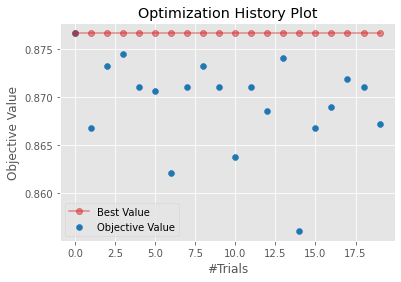

In [43]:
optuna.visualization.matplotlib.plot_optimization_history(cnn_study);

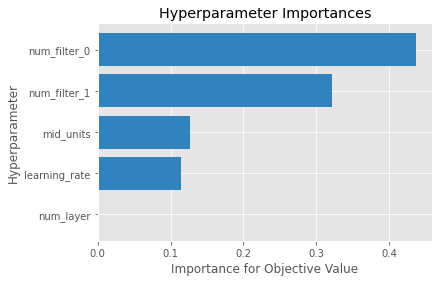

In [44]:
optuna.visualization.matplotlib.plot_param_importances(cnn_study);

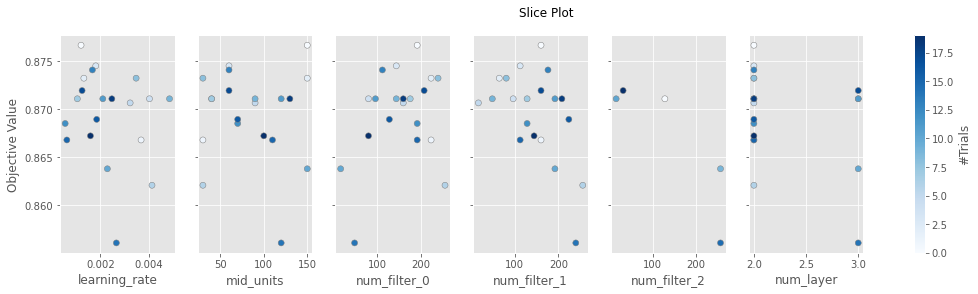

In [45]:
optuna.visualization.matplotlib.plot_slice(cnn_study);

In [46]:
lucky_seeds = [0, 42, 2022] # Lucky seed 늘려가면서 하기

for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # CV 늘려가면서 하기
    cv=np.zeros((train_x.shape[0], 4))
    pred_test = np.zeros((test_x.shape[0], 4), dtype=float)
    es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)
    
    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train.target)):
#         print(f"{n+1} Fold Training.....")
        x_train, y_train = train_x[train_idx], train_y[train_idx]
        x_val, y_val = train_x[val_idx], train_y[val_idx]

        cnn = create_model(cnn_study.best_params['num_layer'], cnn_study.best_params['mid_units'], 
                  [cnn_study.best_params[f'num_filter_{i}'] for i in range(cnn_study.best_params['num_layer'])])

        # ModelCheckpoint Fold마다 갱신
        mc = ModelCheckpoint(f"model_{i+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)

        # 모델 Complie
        optimizer = Adam(learning_rate=cnn_study.best_params['learning_rate'])
        cnn.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
        cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, 
                callbacks=[es,mc], verbose=0)

        # 최고 성능 기록 모델
        best = load_model(f"model_{i+1}.h5")
        
        cv[val_idx,:] = best.predict(x_val)
        #print(f'fold{n+1} multi_logloss: {log_loss(y_val, cv[val_idx, :])}') # Fold마다 점수 체크하려면 주석 해제
        pred_test += best.predict(test_x) / 5 # CV 바꾸면 이 숫자도 똑같이 바꿔야함
    pred_dict['cnn'+str(seed)] = cv
    pred_test_dict['cnn'+str(seed)] = pred_test
#     print(f'seed {seed}', 'multi_logloss :', log_loss(train_y, cv))
    print(f'seed {seed}', 'accuracy_score :', accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1)))

seed 0 accuracy_score : 0.8788008565310492
seed 42 accuracy_score : 0.8702355460385439
seed 2022 accuracy_score : 0.871948608137045


## 4. Stacking (XGB)

In [47]:
def sort_dict(model, pred_dict, pred_test_dict):
    pred_dict_local = {}
    for key, value in pred_dict.items():
        if model in key:
            pred_dict_local[key]=value

    pred_test_dict_local = {}
    for key, value in pred_test_dict.items():
        if model in key:
            pred_test_dict_local[key]=value

    pred_dict_new_local = dict(sorted(pred_dict_local.items(), key=lambda x:log_loss(train_y, list(x[1])), reverse=False)[:3])
    pred_test_dict_new_local = {}
    for key, value in pred_dict_new_local.items():
        pred_test_dict_new_local[key]=pred_test_dict_local[key]
        
    return pred_dict_new_local, pred_test_dict_new_local

In [48]:
pred_dict_lgb, pred_test_dict_lgb = sort_dict('lgb', pred_dict, pred_test_dict)
pred_dict_xgb, pred_test_dict_xgb = sort_dict('xgb', pred_dict, pred_test_dict)
# pred_dict_rf, pred_test_dict_rf = sort_dict('rf', pred_dict, pred_test_dict)
pred_dict_cnn, pred_test_dict_cnn = sort_dict('cnn', pred_dict, pred_test_dict)

In [49]:
def save_dict(model, pred_dict, pred_test_dict):
    with open('./pkl/pred_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_dict, fw)

    with open('./pkl/pred_test_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_test_dict, fw)

In [50]:
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Created Directory :", dir)
    else:
        print("Directory already existed :", dir)
create_dir("pkl")

Directory already existed : pkl


In [51]:
save_dict('lgb', pred_dict_lgb, pred_test_dict_lgb)
save_dict('xgb', pred_dict_xgb, pred_test_dict_xgb)
#save_dict('rf', pred_dict_rf, pred_test_dict_rf)
save_dict('cnn', pred_dict_cnn, pred_test_dict_cnn)

In [52]:
def load_dict(model):
    with open('./pkl/pred_dict_'+model+'.pickle', 'rb') as fw:
        pred_dict_new_local = pickle.load(fw)

    with open('./pkl/pred_test_dict_'+model+'.pickle', 'rb') as fw:
        pred_test_dict_new_local = pickle.load(fw)
        
    return pred_dict_new_local, pred_test_dict_new_local

In [53]:
pred_dict_lgb, pred_test_dict_lgb = load_dict('lgb')
pred_dict_xgb, pred_test_dict_xgb = load_dict('xgb')
# pred_dict_rf, pred_test_dict_rf = load_dict('rf')
pred_dict_cnn, pred_test_dict_cnn = load_dict('cnn')

In [59]:
pred_dict_total = {**pred_dict_lgb, **pred_dict_xgb, **pred_dict_cnn}
pred_test_dict_total = {**pred_test_dict_lgb, **pred_test_dict_xgb, **pred_test_dict_cnn}

In [60]:
train_y = train.iloc[:, -1:]

In [67]:
def stack_objective(trial: Trial) -> float:
    params_xgb = {
        "random_state": 91373,
        "verbose": None,
        "num_class": 4,
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        #"tree_method": "gpu_hist",
        "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.01),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0.1, 1.0),
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0.1, 1.0),
        "max_depth": trial.suggest_int("max_depth", 4, 8),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.5),
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.3, 1.0),
        "subsample": trial.suggest_uniform("subsample", 0.3, 1.0),
        "gamma": trial.suggest_uniform("gamma", 0.3, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    # CV=5로 튜닝
    
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

        x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]
        
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dvalid = xgb.DMatrix(x_val, label=y_val)
        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                            # 진행상황 보고싶을때 None을 100으로
        stack_xgbmodel = xgb.train(params_xgb, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)

        cv[val_idx, :] = stack_xgbmodel.predict(dvalid)
        #print(f'fold{n+1} multi_logloss: {log_loss(y_val, cv[val_idx, :])}') # Fold마다 점수 체크하려면 주석 해제
#     print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(train_y, np.argmax(cv, axis=1)))

    return accuracy_score(train_y, np.argmax(cv, axis=1))

In [68]:
X_train = pd.DataFrame(np.hstack([x for _, x in pred_dict_total.items()]))
X_test = pd.DataFrame(np.hstack([x for _, x in pred_test_dict_total.items()]))

sampler = TPESampler(seed=42)
stack_study = optuna.create_study(study_name="stack_parameter_opt", direction="maximize", sampler=sampler)
stack_study.optimize(stack_objective, n_trials=10)

stack_best_hyperparams = stack_study.best_trial.params
stack_base_hyperparams = {'objective':'multi:softprob', "num_class": 4, "eval_metric": "mlogloss", "random_state": 42}
stack_best_hyperparams.update(stack_base_hyperparams)
print("The best hyperparameters are:\n", stack_best_hyperparams)

[I 2022-03-15 22:48:56,581] A new study created in memory with name: stack_parameter_opt
[I 2022-03-15 22:49:37,677] Trial 0 finished with value: 0.8852248394004283 and parameters: {'learning_rate': 0.004370861069626263, 'reg_alpha': 0.9556428757689246, 'reg_lambda': 0.7587945476302645, 'max_depth': 6, 'colsample_bytree': 0.1624074561769746, 'colsample_bylevel': 0.40919616423534183, 'subsample': 0.3406585285177396, 'gamma': 0.9063233020424546, 'min_child_weight': 7, 'max_bin': 413}. Best is trial 0 with value: 0.8852248394004283.


accuracy_score: 0.8852248394004283


[I 2022-03-15 22:52:31,928] Trial 1 finished with value: 0.8873661670235546 and parameters: {'learning_rate': 0.001185260448662222, 'reg_alpha': 0.9729188669457949, 'reg_lambda': 0.8491983767203796, 'max_depth': 5, 'colsample_bytree': 0.17272998688284025, 'colsample_bylevel': 0.4283831568974037, 'subsample': 0.5129695700716763, 'gamma': 0.6673295021425665, 'min_child_weight': 5, 'max_bin': 287}. Best is trial 1 with value: 0.8873661670235546.


accuracy_score: 0.8873661670235546


[I 2022-03-15 22:52:55,174] Trial 2 finished with value: 0.8856531049250536 and parameters: {'learning_rate': 0.006506676052501416, 'reg_alpha': 0.22554447458683766, 'reg_lambda': 0.3629301836816964, 'max_depth': 5, 'colsample_bytree': 0.28242799368681437, 'colsample_bylevel': 0.8496231729751094, 'subsample': 0.4397716475108518, 'gamma': 0.6599641068895281, 'min_child_weight': 6, 'max_bin': 213}. Best is trial 1 with value: 0.8873661670235546.


accuracy_score: 0.8856531049250536


[I 2022-03-15 22:53:23,793] Trial 3 finished with value: 0.8843683083511777 and parameters: {'learning_rate': 0.006467903667112946, 'reg_alpha': 0.2534717113185624, 'reg_lambda': 0.1585464336867516, 'max_depth': 8, 'colsample_bytree': 0.4862528132298237, 'colsample_bylevel': 0.8658781436815228, 'subsample': 0.5132296384213595, 'gamma': 0.3683704798044687, 'min_child_weight': 7, 'max_bin': 332}. Best is trial 1 with value: 0.8873661670235546.


accuracy_score: 0.8843683083511777


[I 2022-03-15 22:54:43,311] Trial 4 finished with value: 0.8843683083511777 and parameters: {'learning_rate': 0.0020983441136030096, 'reg_alpha': 0.5456592191001431, 'reg_lambda': 0.13094966900369656, 'max_depth': 8, 'colsample_bytree': 0.20351199264000677, 'colsample_bylevel': 0.7637655990477874, 'subsample': 0.5181977532625877, 'gamma': 0.6640476148244676, 'min_child_weight': 6, 'max_bin': 255}. Best is trial 1 with value: 0.8873661670235546.


accuracy_score: 0.8843683083511777


[I 2022-03-15 22:55:04,128] Trial 5 finished with value: 0.8873661670235546 and parameters: {'learning_rate': 0.009726261649881027, 'reg_alpha': 0.7976195410250031, 'reg_lambda': 0.9455490474077702, 'max_depth': 8, 'colsample_bytree': 0.3391599915244341, 'colsample_bylevel': 0.9453119645161818, 'subsample': 0.36194475143634364, 'gamma': 0.4371880036934016, 'min_child_weight': 1, 'max_bin': 297}. Best is trial 1 with value: 0.8873661670235546.


accuracy_score: 0.8873661670235546


[I 2022-03-15 22:55:41,523] Trial 6 finished with value: 0.8860813704496788 and parameters: {'learning_rate': 0.004498095607205339, 'reg_alpha': 0.34421412859650635, 'reg_lambda': 0.8458637582367364, 'max_depth': 5, 'colsample_bytree': 0.2123738038749523, 'colsample_bylevel': 0.6798872582107739, 'subsample': 0.3986469574823338, 'gamma': 0.8615378865278278, 'min_child_weight': 1, 'max_bin': 497}. Best is trial 1 with value: 0.8873661670235546.


accuracy_score: 0.8860813704496788


[I 2022-03-15 22:56:08,673] Trial 7 finished with value: 0.884796573875803 and parameters: {'learning_rate': 0.007950202923669918, 'reg_alpha': 0.2788441133807552, 'reg_lambda': 0.10496990541124217, 'max_depth': 8, 'colsample_bytree': 0.38274293753904687, 'colsample_bylevel': 0.810305017628691, 'subsample': 0.8398892426801621, 'gamma': 0.35183125621386324, 'min_child_weight': 4, 'max_bin': 234}. Best is trial 1 with value: 0.8873661670235546.


accuracy_score: 0.884796573875803


[I 2022-03-15 22:56:29,925] Trial 8 finished with value: 0.8882226980728052 and parameters: {'learning_rate': 0.008767930832880343, 'reg_alpha': 0.6609683141448022, 'reg_lambda': 0.39780822236738433, 'max_depth': 4, 'colsample_bytree': 0.2243929286862649, 'colsample_bylevel': 0.5276283254187228, 'subsample': 0.8107243248366449, 'gamma': 0.7462902299486491, 'min_child_weight': 9, 'max_bin': 342}. Best is trial 8 with value: 0.8882226980728052.


accuracy_score: 0.8882226980728052


[I 2022-03-15 22:58:18,690] Trial 9 finished with value: 0.8869379014989294 and parameters: {'learning_rate': 0.0020763482134447155, 'reg_alpha': 0.7419203085006955, 'reg_lambda': 0.7847065437552077, 'max_depth': 6, 'colsample_bytree': 0.40838687198182444, 'colsample_bylevel': 0.6456569174550735, 'subsample': 0.6659129805673958, 'gamma': 0.5992787128509847, 'min_child_weight': 1, 'max_bin': 232}. Best is trial 8 with value: 0.8882226980728052.


accuracy_score: 0.8869379014989294
The best hyperparameters are:
 {'learning_rate': 0.008767930832880343, 'reg_alpha': 0.6609683141448022, 'reg_lambda': 0.39780822236738433, 'max_depth': 4, 'colsample_bytree': 0.2243929286862649, 'colsample_bylevel': 0.5276283254187228, 'subsample': 0.8107243248366449, 'gamma': 0.7462902299486491, 'min_child_weight': 9, 'max_bin': 342, 'objective': 'multi:softprob', 'num_class': 4, 'eval_metric': 'mlogloss', 'random_state': 42}


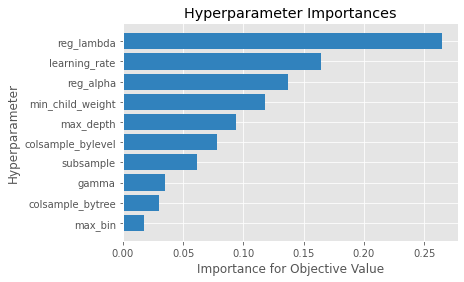

In [69]:
optuna.visualization.matplotlib.plot_param_importances(stack_study);

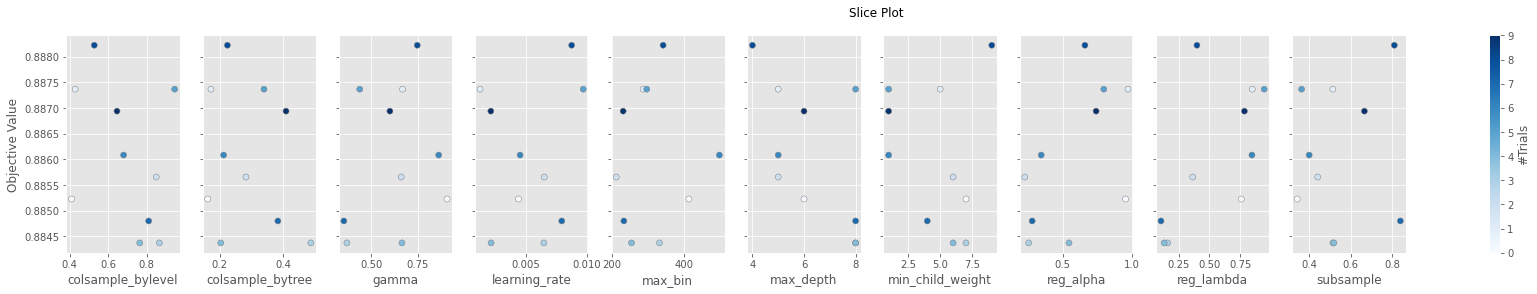

In [70]:
optuna.visualization.matplotlib.plot_slice(stack_study);

In [79]:
pred = np.zeros((X_train.shape[0], 4), dtype=float)
pred_test = np.zeros((X_test.shape[0], 4), dtype=float)
kfold = StratifiedKFold(n_splits=5, random_state = 42, shuffle = True)

for n, (train_idx, val_idx) in enumerate(kfold.split(X_train, train_y)):
    x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]

    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_val, label=y_val)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                        # 진행상황 보고싶을때 None을 100으로
    stack_xgbmodel = xgb.train(stack_best_hyperparams, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)
    
    pred[val_idx] = stack_xgbmodel.predict(dvalid)
    pred_test += stack_xgbmodel.predict(xgb.DMatrix(X_test)) / 5

In [80]:
print(f'CV Log Loss: {log_loss(train_y, pred):.6f}')
print(f'CV Accuracy Score: {accuracy_score(train_y, np.argmax(pred, axis=1)):.6f}')

CV Log Loss: 0.329595
CV Accuracy Score: 0.885225


In [81]:
stack_train = pred.copy()
stack_test = pred_test.copy()

## 5. Blending

In [114]:
pred_final = (sum(pred_dict_lgb.values())/3 * 1 +
              sum(pred_dict_xgb.values())/3 * 1 +
               sum(pred_dict_cnn.values())/3 * 5 +
                               stack_train * 8)
accuracy_score(train_y, np.argmax(pred_final, axis=1))

0.8907922912205567

In [109]:
pred_test_final = (sum(pred_test_dict_lgb.values())/3 * 1 +
                   sum(pred_test_dict_xgb.values())/3 * 1 +
                    sum(pred_test_dict_cnn.values())/3 * 5 +
                                          stack_test * 8)

## 6. Submission

In [110]:
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Created Directory :", dir)
    else:
        print("Directory already existed :", dir)
create_dir("submission")

Directory already existed : submission


In [111]:
submission['target'] = np.argmax(pred_test_final, axis=1)
submission.to_csv('submission/20220315-3.csv', index = False)
submission.target.value_counts()

1    2461
2    2398
0    2282
3    2202
Name: target, dtype: int64